# Comparison of disease- and PRS-associated phenotypes

In [1]:
import pandas as pd
import numpy as np
import pp, cna, os, pickle
pp.umapprops['s'] = 0.6
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import scipy.stats as st
import statsmodels.api as sm
fig_dir = '/data/srlab/lrumker/MCSC_Project/cna-prs/figs/'
src_folder = "/data/srlab/lrumker/datasets/onek1k/pheno/"
res_folder = "/data/srlab/lrumker/MCSC_Project/cna-prs/results/"
np.random.seed(0)

In [2]:
curr_dir = os.getcwd()
os.chdir('/data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA-applied/notebooks/')
from figure_functions import *
os.chdir(curr_dir)

In [3]:
# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

## Helper functions

In [4]:
# Evaluate sigificance of correlation between phenotype value and RA PRS value
def perm_test(trait_name, d, show_plot = False, verbose = False):
    np.random.seed(0)
    
    trait_df = d.samplem.loc[:,[trait_name, 'RA']]
    trait_df = trait_df.loc[~pd.isna(trait_df[trait_name].values),:].reset_index(drop = True)
    
    obs_val = np.corrcoef(trait_df.RA.values, trait_df[trait_name].values)[0,1]
    perm_vals=[]
    for n_perm in np.arange(1000):
        perm_vals.append(np.corrcoef(np.random.choice(trait_df.RA.values,trait_df.shape[0], replace=False), 
                                 trait_df[trait_name].values)[0,1])
    pval = np.sum(np.abs(perm_vals)>np.abs(obs_val))/len(perm_vals)
    if verbose:
        print("R="+str(obs_val))
        print("Perm P="+str(pval))
    
    if show_plot:
        plt.hist(np.abs(perm_vals), bins = 30)
        plt.axvline(x=np.abs(obs_val), c = "red")
        
    return obs_val, pval

In [5]:
# Performs a two-sided t-test for values of the trait of interest beween RA and non-RA cohorts
# Removes individuals with NaN trait values, if relevant
def trait_test(trait, d):
    trait_df = d.samplem.loc[:,[trait, 'Rheumatoid_arthritis']]
    trait_df.columns = ['test_trait', 'Rheumatoid_arthritis']
    trait_df = trait_df.loc[~pd.isna(trait_df.test_trait),:].reset_index(drop = True)
    pval_trait = st.ttest_ind(trait_df.test_trait.values[trait_df.Rheumatoid_arthritis==0], 
                 trait_df.test_trait.values[trait_df.Rheumatoid_arthritis==1])[1]
    rval = np.corrcoef(trait_df.test_trait.values, trait_df.Rheumatoid_arthritis.values)[0,1]
    return rval, pval_trait

## Load results objects

In [6]:
# From PRS association test
PRS = pd.read_csv("/data/srlab/lrumker/MCSC_Project/cna-prs/results/PRS/RA_PRS_noMHC.csv", index_col = 0)
PRS.set_index('IDs', inplace = True, drop = True)
PRS.columns = ['RA']
d_prs = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/allcells.h5ad")
d_prs.samplem = d_prs.samplem.join(PRS)
res_prs = pickle.load(open("/data/srlab/lrumker/MCSC_Project/cna-prs/results/PRS/RA_allcells.p", 'rb'))
UMAP1_prs=d_prs.obsm['X_umap'][res_prs.kept,0]
UMAP2_prs=d_prs.obsm['X_umap'][res_prs.kept,1]

In [7]:
# From RA case-control association test
d_cc = cna.read("/data/srlab/lrumker/MCSC_Project/cna-prs/results/sc_objects/1K1K_casecontrol_allcells.h5ad")
res_cc = pickle.load(open("/data/srlab/lrumker/MCSC_Project/cna-prs/results/RA_casecontrol/1K1K_casecontrol_"\
                            +"allcells.p", 'rb'))
UMAP1_cc=d_cc.obsm['X_umap'][res_cc.kept,0]
UMAP2_cc=d_cc.obsm['X_umap'][res_cc.kept,1]

## Visualize results

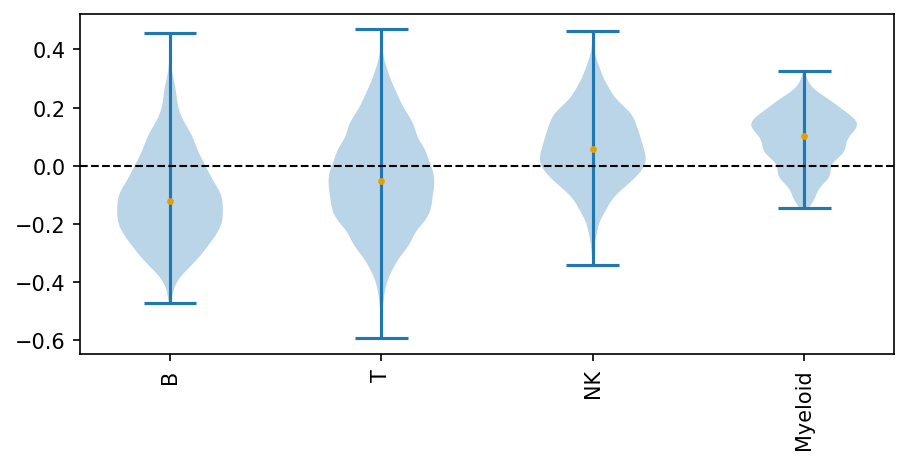

In [8]:
# Examine distribution of abundance correlations across major celltypes
res = res_cc
d = d_cc
fig = plt.figure(figsize=(7,3), dpi = 150)
sel_types = ["B", "T", "NK", "Myeloid"]
ncorrs_celltype = []
medians = []
for sel_type in sel_types:
    ncorrs_celltype.append(res.ncorrs[d.obs.majortype[res.kept]==sel_type])
    medians.append(np.median(res.ncorrs[d.obs.majortype[res.kept]==sel_type]))
    
order = np.argsort(medians)
ncorrs_celltype=[ncorrs_celltype[i] for i in order]
sel_types = [sel_types[i] for i in order]
medians = [medians[i] for i in order]
plt.violinplot(ncorrs_celltype)
plt.scatter(np.arange(len(ncorrs_celltype))+1, medians, s = 5, c = color_dict['orange'], alpha =1, zorder = 10)
plt.xticks(np.arange(len(ncorrs_celltype))+1, labels = sel_types, rotation=90)
plt.axhline(y=0, c= "black", lw = 1, ls="--")
plt.show()

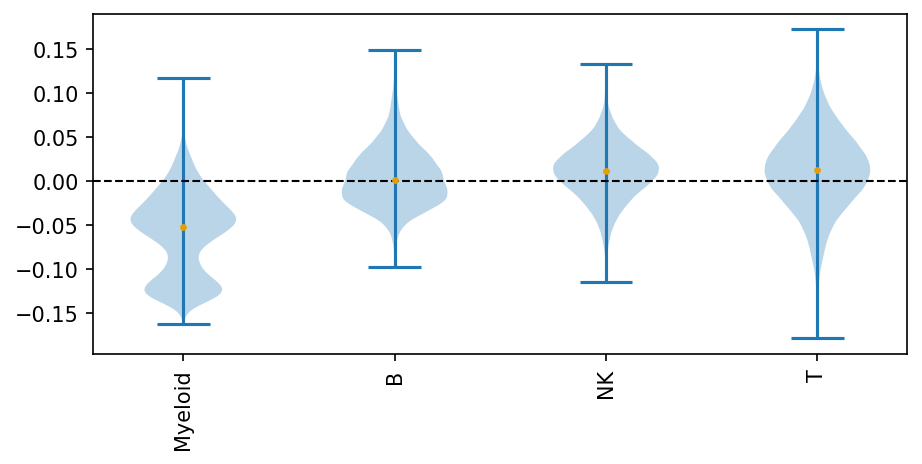

In [9]:
# Examine distribution of abundance correlations across major celltypes
res = res_prs
d = d_prs
fig = plt.figure(figsize=(7,3), dpi = 150)
sel_types = ["B", "T", "NK", "Myeloid"]
ncorrs_celltype = []
medians = []
for sel_type in sel_types:
    ncorrs_celltype.append(res.ncorrs[d.obs.majortype[res.kept]==sel_type])
    medians.append(np.median(res.ncorrs[d.obs.majortype[res.kept]==sel_type]))
    
order = np.argsort(medians)
ncorrs_celltype=[ncorrs_celltype[i] for i in order]
sel_types = [sel_types[i] for i in order]
medians = [medians[i] for i in order]
plt.violinplot(ncorrs_celltype)
plt.scatter(np.arange(len(ncorrs_celltype))+1, medians, s = 5, c = color_dict['orange'], alpha =1, zorder = 10)
plt.xticks(np.arange(len(ncorrs_celltype))+1, labels = sel_types, rotation=90)
plt.axhline(y=0, c= "black", lw = 1, ls="--")
plt.show()

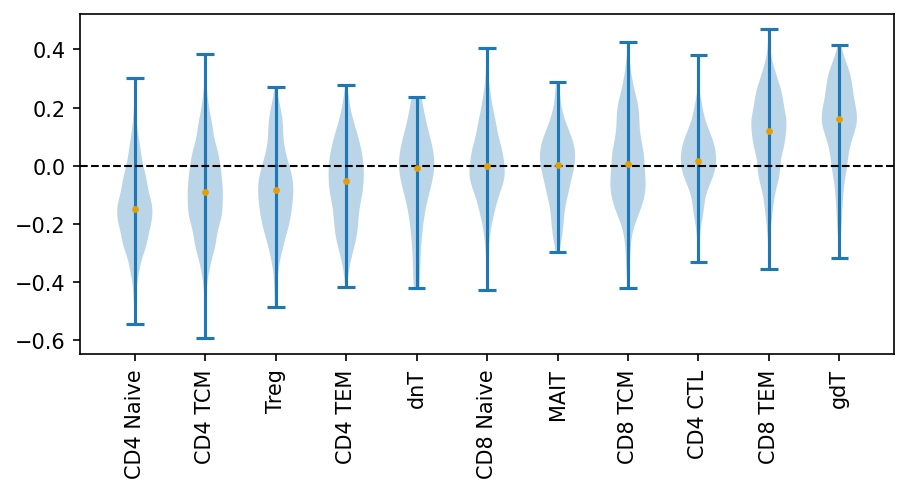

In [10]:
# Examine distribution of abundance correlations across clusters
# Are there any suggested abundance shifts among T cell types? 
res = res_cc
d = d_cc
fig = plt.figure(figsize=(7,3), dpi = 150)
T_types = np.unique(d.obs.celltype[d.obs.majortype=="T"].values)
T_types = [T_types[i] for i in np.arange(len(T_types)) if "Proliferating" not in T_types[i]]
ncorrs_celltype = []
medians = []
for sel_type in T_types:
    ncorrs_celltype.append(res.ncorrs[d.obs.celltype[res.kept]==sel_type])
    medians.append(np.median(res.ncorrs[d.obs.celltype[res.kept]==sel_type]))
    
order = np.argsort(medians)
ncorrs_celltype=[ncorrs_celltype[i] for i in order]
T_types = [T_types[i] for i in order]
medians = [medians[i] for i in order]
plt.violinplot(ncorrs_celltype)
plt.scatter(np.arange(len(ncorrs_celltype))+1, medians, s = 5, c = color_dict['orange'], alpha =1, zorder = 10)
plt.xticks(np.arange(len(ncorrs_celltype))+1, labels = T_types, rotation=90)
plt.axhline(y=0, c= "black", lw = 1, ls="--")
plt.show()

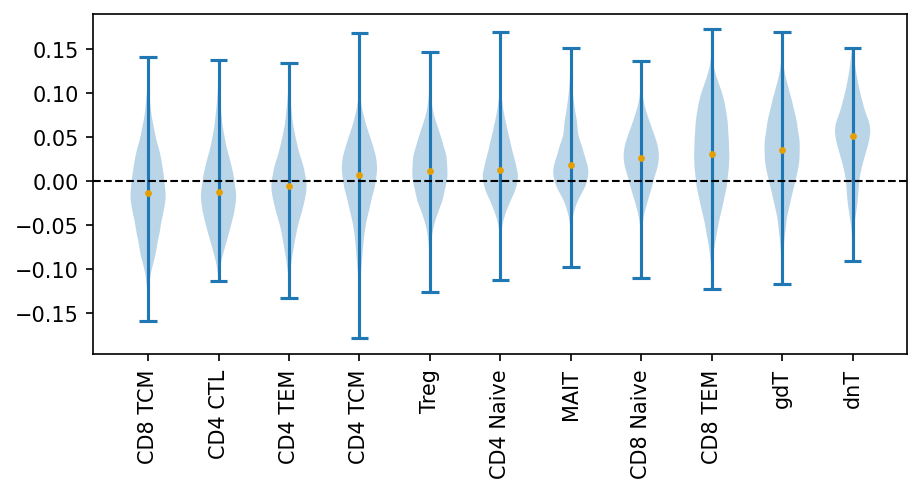

In [11]:
# Examine distribution of abundance correlations across clusters
# Are there any suggested abundance shifts among T cell types? 
res = res_prs
d = d_prs
fig = plt.figure(figsize=(7,3), dpi = 150)
T_types = np.unique(d.obs.celltype[d.obs.majortype=="T"].values)
T_types = [T_types[i] for i in np.arange(len(T_types)) if "Proliferating" not in T_types[i]]
ncorrs_celltype = []
medians = []
for sel_type in T_types:
    ncorrs_celltype.append(res.ncorrs[d.obs.celltype[res.kept]==sel_type])
    medians.append(np.median(res.ncorrs[d.obs.celltype[res.kept]==sel_type]))
    
order = np.argsort(medians)
ncorrs_celltype=[ncorrs_celltype[i] for i in order]
T_types = [T_types[i] for i in order]
medians = [medians[i] for i in order]
plt.violinplot(ncorrs_celltype)
plt.scatter(np.arange(len(ncorrs_celltype))+1, medians, s = 5, c = color_dict['orange'], alpha =1, zorder = 10)
plt.xticks(np.arange(len(ncorrs_celltype))+1, labels = T_types, rotation=90)
plt.axhline(y=0, c= "black", lw = 1, ls="--")
plt.show()

## Directly test cluster-based relationships suggested by neighborhood abundance corrs

(CD4+ T$_{naive}$) / (CD4+ T$_{EM}$+T$_{CTL}$) per individual
Control: 16 , RA:  16
(CD4+ T$_{naive}$) / (CD4+ T$_{EM}$+T$_{CTL}$) per individual
Lower 95%: 920 , Top 5%:  49


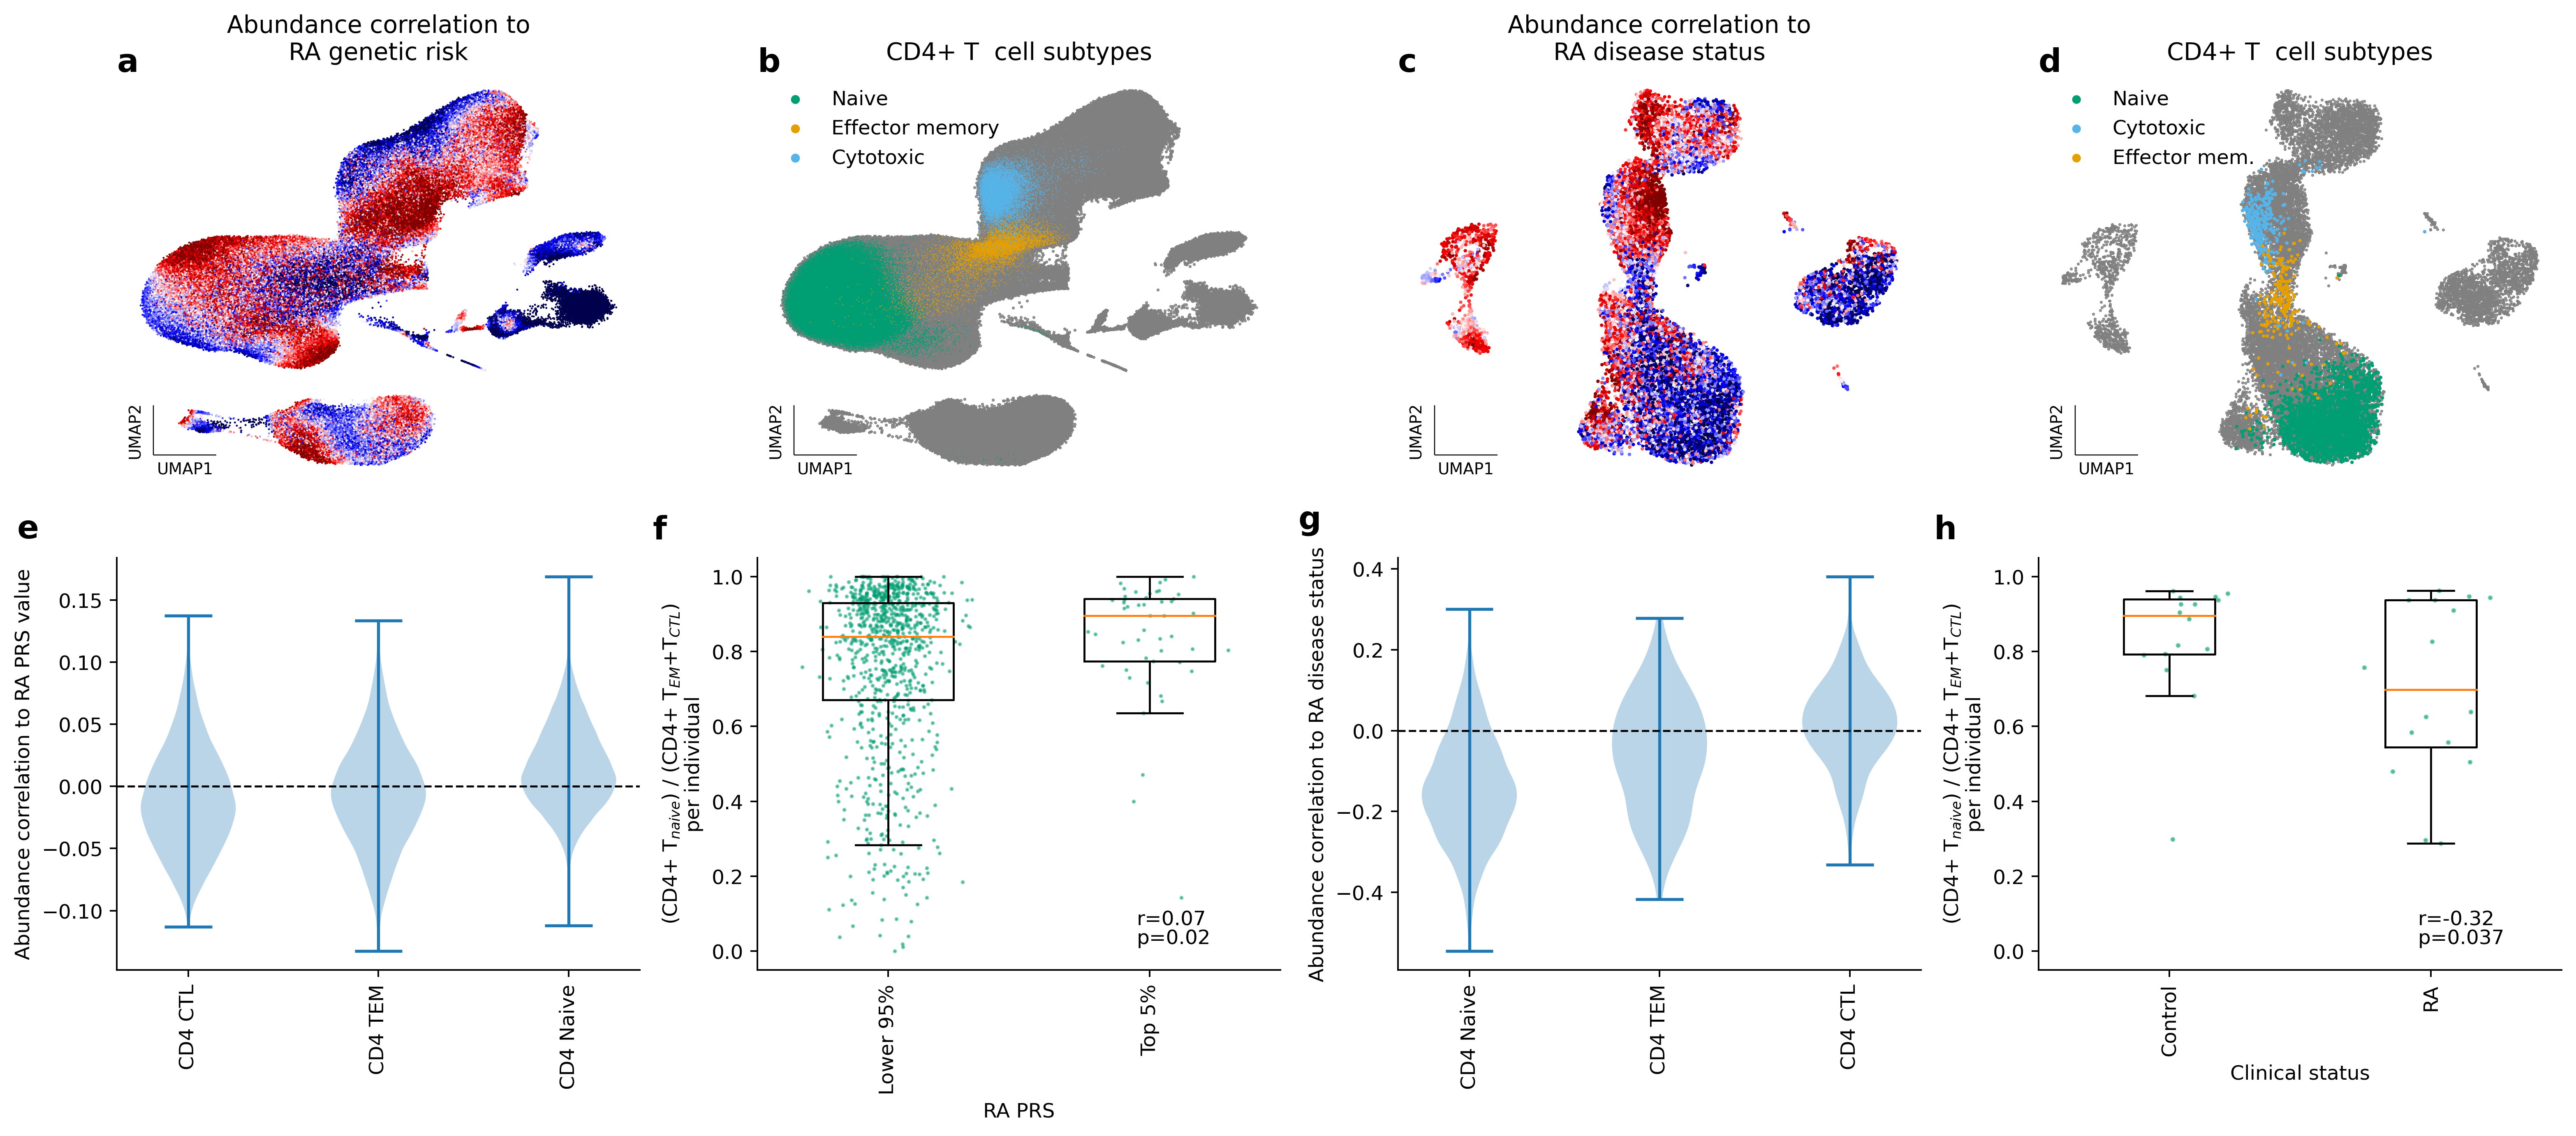

In [12]:
fit, axes = plt.subplots(2,4, figsize=(18,8), dpi=350)

ax = axes[0,0]
pp.umapprops['s'] = 1
pp.scatter_random(UMAP1_prs, UMAP2_prs, c = res_prs.ncorrs, cmap = "seismic", ax = ax)
ax.axis("off")
ax.set_title("Abundance correlation to\nRA genetic risk")
add_umap_axes(ax, umap_axis_length = 0.12, umap_axis_offset = 0.07, 
              axis_lw = 0.5, umap_text_size = 8)
ax.text(0,1,'a', fontsize=16, fontweight="bold", transform = ax.transAxes)

ax = axes[0,1]
ax.scatter(UMAP1_prs, UMAP2_prs, c = "grey", s = 0.2)
mask = d_prs.obs.celltype[res_prs.kept]=="CD4 Naive"
ax.scatter(UMAP1_prs[mask], UMAP2_prs[mask], c = color_dict['green'], s = 0.2, edgecolor = 'none', label = "Naive")
mask = d_prs.obs.celltype[res_prs.kept]=="CD4 TEM"
ax.scatter(UMAP1_prs[mask], UMAP2_prs[mask], c = color_dict['orange'], s = 0.2, edgecolor = 'none', label = "Effector memory")
mask = d_prs.obs.celltype[res_prs.kept]=="CD4 CTL"
ax.scatter(UMAP1_prs[mask], UMAP2_prs[mask], c = color_dict['skyblue'], s = 0.2, edgecolor = 'none', label = "Cytotoxic")
ax.legend(loc="upper left", frameon=False, markerscale=10)
ax.axis("off")
ax.set_title("CD4+ T  cell subtypes")
add_umap_axes(ax, umap_axis_length = 0.12, umap_axis_offset = 0.07, 
              axis_lw = 0.5, umap_text_size = 8)
ax.text(0,1,'b', fontsize=16, fontweight="bold", transform = ax.transAxes)

ax = axes[0,2]
pp.umapprops['s'] = 3
pp.scatter_random(UMAP1_cc, UMAP2_cc, c = res_cc.ncorrs, cmap = "seismic", ax = ax)
ax.axis("off")
ax.set_title("Abundance correlation to\nRA disease status")
add_umap_axes(ax, umap_axis_length = 0.12, umap_axis_offset = 0.07, 
              axis_lw = 0.5, umap_text_size = 8)
ax.text(0,1,'c', fontsize=16, fontweight="bold", transform = ax.transAxes)

ax = axes[0,3]
ax.scatter(UMAP1_cc, UMAP2_cc, c = "grey", s = 0.2)
mask = d_cc.obs.celltype[res_cc.kept]=="CD4 Naive"
ax.scatter(UMAP1_cc[mask], UMAP2_cc[mask], c = color_dict['green'], s = 3, edgecolor = 'none', label = "Naive")
mask = d_cc.obs.celltype[res_cc.kept]=="CD4 CTL"
ax.scatter(UMAP1_cc[mask], UMAP2_cc[mask], c = color_dict['skyblue'], s = 3, edgecolor = 'none', label = "Cytotoxic")
mask = d_cc.obs.celltype[res_cc.kept]=="CD4 TEM"
ax.scatter(UMAP1_cc[mask], UMAP2_cc[mask], c = color_dict['orange'], s = 3, edgecolor = 'none', label = "Effector mem.")
ax.legend(loc="upper left", frameon=False, markerscale=2.5)
ax.axis("off")
add_umap_axes(ax, umap_axis_length = 0.12, umap_axis_offset = 0.07, 
              axis_lw = 0.5, umap_text_size = 8)
ax.set_title("CD4+ T  cell subtypes")
ax.text(0,1,'d', fontsize=16, fontweight="bold", transform = ax.transAxes)

ax = axes[1,0]
T_types = ['CD4 Naive', 'CD4 TEM', 'CD4 CTL']
res = res_prs
d = d_prs
ncorrs_celltype = []
medians = []
for sel_type in T_types:
    ncorrs_celltype.append(res.ncorrs[d.obs.celltype[res.kept]==sel_type])
    medians.append(np.median(res.ncorrs[d.obs.celltype[res.kept]==sel_type]))  
order = np.argsort(medians)
ncorrs_celltype=[ncorrs_celltype[i] for i in order]
T_types = [T_types[i] for i in order]
medians = [medians[i] for i in order]
ax.violinplot(ncorrs_celltype)
ax.set_xticks(np.arange(len(ncorrs_celltype))+1)
ax.set_xticklabels(T_types, rotation=90)
ax.axhline(y=0, c= "black", lw = 1, ls="--")
ax.set_ylabel("Abundance correlation to RA PRS value")
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.1,0.2,'e', fontsize=16, fontweight="bold")

ax = axes[1,2]
res = res_cc
d = d_cc
ncorrs_celltype = []
medians = []
for sel_type in T_types:
    ncorrs_celltype.append(res.ncorrs[d.obs.celltype[res.kept]==sel_type])
    medians.append(np.median(res.ncorrs[d.obs.celltype[res.kept]==sel_type]))
order = np.argsort(medians)
ncorrs_celltype=[ncorrs_celltype[i] for i in order]
T_types = [T_types[i] for i in order]
medians = [medians[i] for i in order]
ax.violinplot(ncorrs_celltype)
ax.set_xticks(np.arange(len(ncorrs_celltype))+1)
ax.set_xticklabels(T_types, rotation=90)
ax.axhline(y=0, c= "black", lw = 1, ls="--")
ax.set_ylabel("Abundance correlation to RA disease status")
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.1,0.5,'g', fontsize=16, fontweight="bold")

np.random.seed(0)
ax = axes[1,3]
d_cc.obs['T_Naive_to_CTL_TEM'] = np.repeat(np.nan, d_cc.obs.shape[0])
d_cc.obs.loc[d_cc.obs.celltype=='CD4 Naive', 'T_Naive_to_CTL_TEM'] = 1
d_cc.obs.loc[d_cc.obs.celltype=='CD4 TEM', 'T_Naive_to_CTL_TEM'] = 0
d_cc.obs.loc[d_cc.obs.celltype=='CD4 CTL', 'T_Naive_to_CTL_TEM'] = 0
d_cc.obs_to_sample('T_Naive_to_CTL_TEM', aggregate=np.mean)
rval, pval = trait_test('T_Naive_to_CTL_TEM', d_cc)
pval = pval/2 # we specifically test the hypothesis suggested by ncorrs
ax.scatter(1+np.random.normal(0,0.1,np.sum(d_cc.samplem.Rheumatoid_arthritis==0)), 
           d_cc.samplem.T_Naive_to_CTL_TEM.values[d_cc.samplem.Rheumatoid_arthritis==0], s = 2, alpha=0.5, c=color_dict["green"])
ax.scatter(2+np.random.normal(0,0.1,np.sum(d_cc.samplem.Rheumatoid_arthritis==1)), 
           d_cc.samplem.T_Naive_to_CTL_TEM.values[d_cc.samplem.Rheumatoid_arthritis==1], s = 2, alpha=0.5, c=color_dict["green"])
ax.boxplot([d_cc.samplem.T_Naive_to_CTL_TEM.values[d_cc.samplem.Rheumatoid_arthritis==0], 
             d_cc.samplem.T_Naive_to_CTL_TEM.values[d_cc.samplem.Rheumatoid_arthritis==1]], 
           showfliers=False, widths = 0.35)
ax.set_xticklabels(['Control', 'RA'], rotation=90)
ax.text(1.95, 0.07, "r="+str(np.around(rval, 2)))
ax.text(1.95, 0.02, "p="+str(np.around(pval, 3)))
ax.set_ylim([-0.05,1.05])
ax.set_xlabel("Clinical status")
ax.set_ylabel("(CD4+ T$_{naive}$) / (CD4+ T$_{EM}$+T$_{CTL}$)\nper individual")
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.1,1.1,'h', fontsize=16, fontweight="bold")
print("(CD4+ T$_{naive}$) / (CD4+ T$_{EM}$+T$_{CTL}$) per individual")
print("Control: "+str(np.sum(d_cc.samplem.Rheumatoid_arthritis==0)),", RA: ",
      str(np.sum(d_cc.samplem.Rheumatoid_arthritis==1)))

ax = axes[1,1]
d_prs.obs['T_Naive_to_CTL_TEM'] = np.repeat(np.nan, d_prs.obs.shape[0])
d_prs.obs.loc[d_prs.obs.celltype=='CD4 Naive', 'T_Naive_to_CTL_TEM'] = 1
d_prs.obs.loc[d_prs.obs.celltype=='CD4 TEM', 'T_Naive_to_CTL_TEM'] = 0
d_prs.obs.loc[d_prs.obs.celltype=='CD4 CTL', 'T_Naive_to_CTL_TEM'] = 0
d_prs.obs_to_sample('T_Naive_to_CTL_TEM', aggregate=np.mean)
rval, pval = perm_test('T_Naive_to_CTL_TEM', d_prs)
pval = pval/2 # we only specifically test the hypothesis suggested by ncorrs
PRS_thresh = np.quantile(d_prs.samplem.RA, 0.95)
ax.scatter(1+np.random.normal(0,0.1,np.sum(d_prs.samplem.RA<PRS_thresh)), 
           d_prs.samplem.T_Naive_to_CTL_TEM.values[d_prs.samplem.RA<PRS_thresh], s=1, alpha=0.5, c=color_dict["green"])
ax.scatter(2+np.random.normal(0,0.1,np.sum(d_prs.samplem.RA>=PRS_thresh)), 
           d_prs.samplem.T_Naive_to_CTL_TEM.values[d_prs.samplem.RA>=PRS_thresh], s=1, alpha=0.5, c=color_dict["green"])
ax.boxplot([d_prs.samplem.T_Naive_to_CTL_TEM.values[d_prs.samplem.RA<PRS_thresh], 
             d_prs.samplem.T_Naive_to_CTL_TEM.values[d_prs.samplem.RA>=PRS_thresh]], showfliers=False, widths = 0.5)
ax.set_xticklabels(['Lower 95%', 'Top 5%'], rotation=90)
ax.text(1.95, 0.07, "r="+str(np.around(rval, 2)))
ax.text(1.95, 0.02, "p="+str(np.around(pval, 3)))
ax.set_xlabel("RA PRS")
ax.set_ylim([-0.05,1.05])
ax.set_ylabel("(CD4+ T$_{naive}$) / (CD4+ T$_{EM}$+T$_{CTL}$)\nper individual")
ax.spines[['right', 'top']].set_visible(False)
ax.text(0.1,1.1,'f', fontsize=16, fontweight="bold")
print("(CD4+ T$_{naive}$) / (CD4+ T$_{EM}$+T$_{CTL}$) per individual")
print("Lower 95%: "+str(np.sum(d_prs.samplem.RA<PRS_thresh)),", Top 5%: ",
      str(np.sum(d_prs.samplem.RA>=PRS_thresh)))

plt.tight_layout()
plt.savefig(fig_dir+"suppfig.RA_CC_PRS.png")
plt.show()